## Recommendation Systems

**Introduction** <br>
Be honest – how many times have you used the ‘Recommended for you’ section on Amazon? Ever since I found out a few years back that machine learning powers this section – I have been hooked. I keep an eye on that section each time I log into Amazon.

There’s a reason companies like Netflix, Google, Amazon, Flipkart, etc. spend millions perfecting their recommendation engine. It is a powerful acquisition channel and enhances the customer’s experience.

In this notebook, we are going to build our own recommendation system. But I will approach this from a unique perspective. I will use Word2vec, an NLP concept, to recommend products to users.

### Introduction to word2vec – Vector Representation of Words
We know that machines struggle to deal with raw text data. In fact, it’s almost impossible for machines to deal with anything except for numerical data. So representing text in the form of vectors has always been the most important step in almost all NLP tasks.

One of the most significant steps in this direction has been the use of word2vec embeddings, introduced to the NLP community in 2013. It completely changed the entire landscape of NLP.

These embeddings proved to be state-of-the-art for tasks like word analogies and word similarities. word2vec embeddings were also able to achieve tasks like King – man +woman ~= Queen, which was considered an almost magical result.

Now, there are two variants of a word2vec model ⁠— Continuous Bag of Words and Skip-Gram model. In this article, we will use the Skip-Gram model.

In [1]:
## Import all the required packages


import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [2]:
# Read the file which contains the Lending Club's data
retail = pd.read_excel('Online Retail.xlsx')
# retail = pd.read_csv("Online.csv")

In [3]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Here is the description of the fields in this dataset:

**InvoiceNo:** Invoice number. a unique number assigned to each transaction <br>
**StockCode:** Product/item code. a unique number assigned to each distinct product <br>
**Description:** Product description <br>
**Quantity:** The quantities of each product per transaction <br>
**InvoiceDate:** Invoice Date and time. The day and time when each transaction was generated <br>
**CustomerID:** Customer number. a unique number assigned to each customer

# Exploratory Data Analysis (EDA)

In [4]:
#Understanding the file

retail.shape

(541909, 8)

In [5]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


### Treat Missing Data

In [7]:
# check for missing values
retail.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Since we have sufficient data, we will drop all the rows with missing values.

In [8]:
# remove missing values
retail.dropna(inplace=True)

### Data Preparation

Let’s convert the StockCode to string datatype:

In [9]:
retail['StockCode']= retail['StockCode'].astype(str)

Let’s check out the number of unique customers in our dataset:

In [10]:
customers = retail["CustomerID"].unique().tolist()
len(customers)

4372

There are 4,372 customers in our dataset. For each of these customers, we will extract their buying history. In other words, we can have 4,372 sequences of purchases.

It is a good practice to set aside a small part of the dataset for validation purposes. Therefore, I will use the data of 90% of the customers to create word2vec embeddings. Let’s split the data.

In [11]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_retail = retail[retail['CustomerID'].isin(customers_train)]
validation_retail = retail[~retail['CustomerID'].isin(customers_train)]

In [12]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = train_retail[train_retail["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:08<00:00, 482.73it/s]


In [13]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm(validation_retail['CustomerID'].unique()):
    temp = validation_retail[validation_retail["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 840.78it/s]


In [14]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

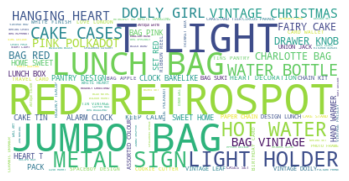

In [15]:
# Start with one review:
#text = retail.Description[0]
text = " ".join(review for review in retail.Description)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
retail.corr()

,Quantity,UnitPrice,CustomerID
Quantity,1.000000,-0.001238,-0.00360
UnitPrice,-0.001238,1.000000,-0.00456
CustomerID,-0.003600,-0.004560,1.00000


In [17]:
import sweetviz as sv

In [18]:
retail = retail.drop(['InvoiceNo'],axis=1)

In [19]:
retail_report = sv.analyze(retail)

:FEATURES DONE:                    |█████████████████████| [100%]   00:05  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:02  -> (00:00 left)


Creating Associations graph... DONE!


In [20]:
retail_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.
